<a href="https://colab.research.google.com/github/JOEL1706/data-Science/blob/main/Time_Series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series

### Load the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### Load the Dataset

In [ ]:
df=pd.read_csv(r"/content/exchange_rate.csv",index_col=0,parse_dates=True,dayfirst=True)
df.shape

(7588, 1)

Our Dataset contains 7588 rows and 1 column.

index_col=0 makes the first column as index, parse_dates=True makes the specified column (or columns) parsed as datetime objects instead of strings, allowing for easier time-based analysis.,dayfirst=True makes the first column as day.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


### Duplicates

In [ ]:
df.index.duplicated().sum()

np.int64(0)

### Missing values

In [ ]:
df.isnull().sum()

,0
Ex_rate,0


We dont have any duplicates or missing values in our dataset.

### Visualization

<Axes: xlabel='date'>

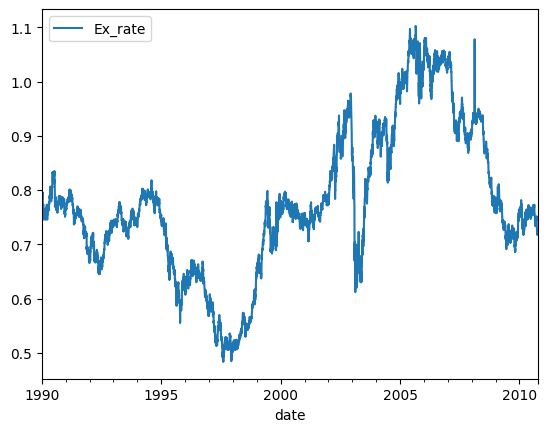

In [ ]:
df.plot()

* **Trend:** The plot likely shows an overall upward, downward, or sideways trend in the exchange rate over time.  An upward trend suggests appreciation of the currency, while a downward trend suggests depreciation. A flat trend suggests relative stability.
* **Seasonality:**  The plot might exhibit seasonal patterns, meaning repeating fluctuations at regular intervals (e.g., daily, weekly, monthly, yearly).  For exchange rates, seasonality could be influenced by economic events or holidays that occur regularly.

### Moving Average Plot

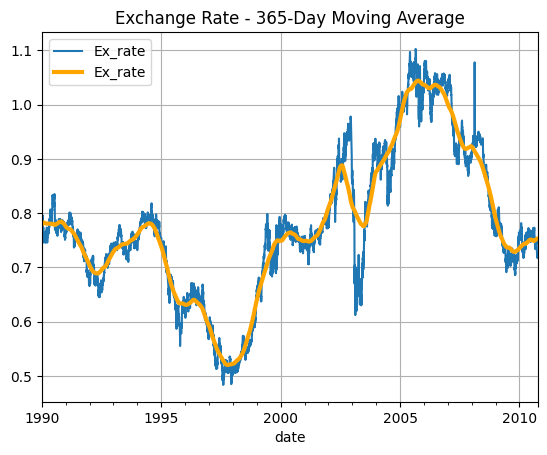

In [ ]:
# Plot original data
ax = df.plot(label="Original Data")

# Compute and plot the 365-day moving average
moving_average = df.rolling(
    window=365,       # 365-day window
    center=True,      # Puts the average at the center of the window
    min_periods=183,  # Choose about half the window size
).mean()

# Plot the moving average
moving_average.plot(ax=ax,color="orange",linewidth=3)

# Add title and legend
plt.title("Exchange Rate - 365-Day Moving Average")
plt.legend()

# Display grid and plot
plt.grid(True)
plt.show()


The 365-day moving average smooths out the short-term fluctuations in the exchange rate data, revealing the underlying trend more clearly.  The moving average line will lag behind the original data due to the averaging process over the 365-day window.  Comparing the original data to the moving average helps visualize the degree of volatility in the exchange rate and identify any significant shifts or trends.  The `min_periods` parameter ensures that the moving average is calculated even when there is less than a full 365 days of data available.

array([[<Axes: title={'center': 'Ex_rate'}>]], dtype=object)

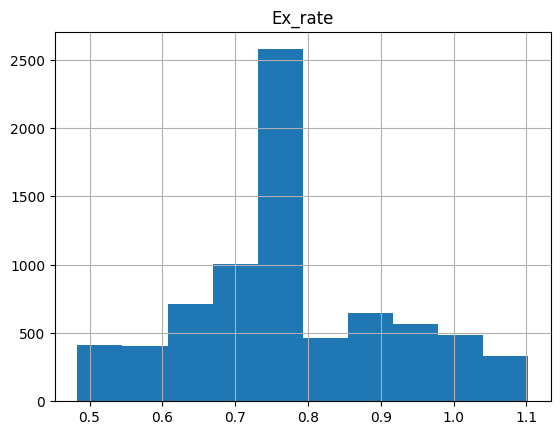

In [ ]:
df.hist()

<Axes: >

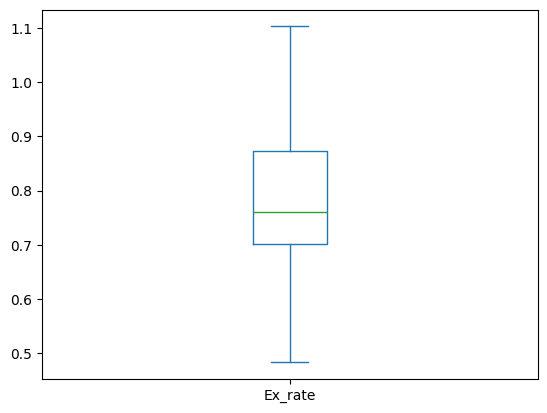

In [ ]:
df.plot(kind='box')

<Axes: ylabel='Density'>

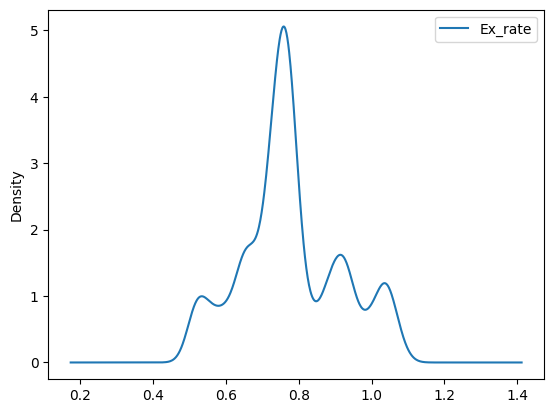

In [ ]:
df.plot(kind='kde')

### adfuller Test for Stationarity.

In [ ]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

check_stationarity(df["Ex_rate"])

ADF Statistic: -1.6649941807382342
P-value: 0.4492327353597477
The series is NOT stationary.


adfuller test confrims that our data is not stationary.

### Seasonal Decomposition

Seasonal decomposition is applied to understand the underlying structure of the time series data.  It is useful for:

1. **Identifying Trends:**  Helps visualize and quantify the overall trend in the exchange rate,  making it easier to predict future behavior.

2. **Detecting Seasonality:** Allows to see if there are repeating patterns and their strength. This is crucial in forecasting as these patterns must be accounted for in any predictive model.

3. **Model Building:**  A decomposed time series can be used to build more accurate forecasting models. For instance, you might use ARIMA or other time series models on the detrended and deseasonalized data (the residuals). After forecasting the residuals, you can add the trend and seasonality components back to get the final forecast.

4. **Anomaly Detection:**  Analyzing the residuals can help identify outliers or unexpected fluctuations in the data that don't conform to the overall trend or seasonality.

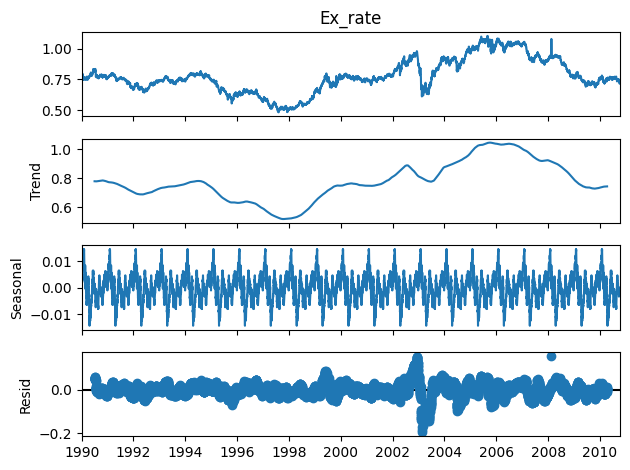

In [ ]:
# Decompose the time series into trend, seasonal, and residuals
result = seasonal_decompose(df["Ex_rate"], model="additive", period=365)
result.plot()
plt.show()

**Observations**

**Trend:** The trend component shows a general upward trend in the exchange rate over the years. However, there is some variation in the trend which includes periods of relative stability and even slight declines. This means that, overall, the exchange rate has been generally increasing but not always at a constant rate.

**Seasonality:** The seasonal component shows a clear pattern of repeating fluctuations throughout the year. This indicates a yearly seasonality to the data. The magnitude of the seasonal fluctuations appears to be relatively consistent across the years. This consistent pattern suggests that certain times of the year have a predictable impact on exchange rates.

**Residuals:** The residual component represents the remaining variability in the exchange rate data after accounting for the trend and seasonality. The residuals appear to fluctuate randomly around zero, indicating a good model fit. However, there might be some periods with slightly larger fluctuations, indicating periods where the model's predictions might be less accurate.

### ACF and PACF Plots

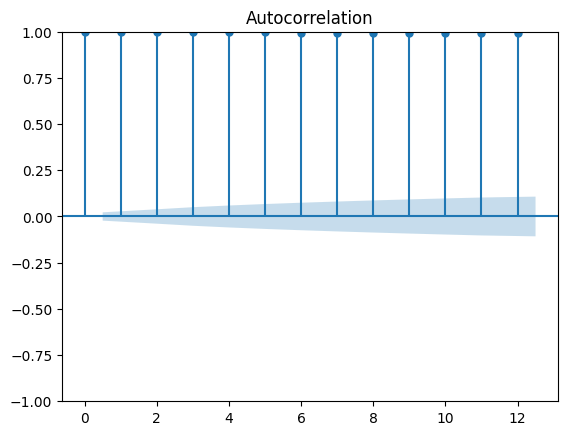

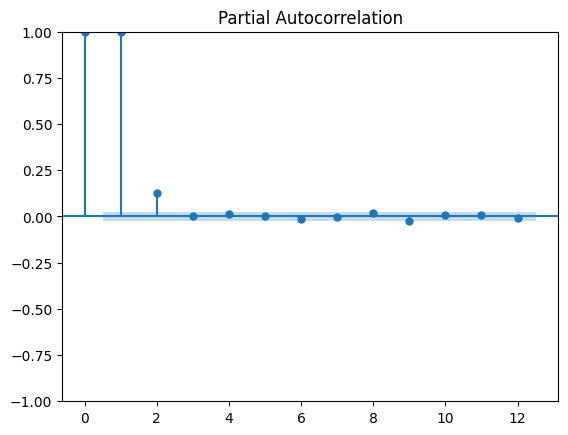

In [ ]:
plot_acf(df.Ex_rate,lags=12)
plot_pacf(df.Ex_rate,lags=12)
plt.show()

The ACF plot reveals significant, positive autocorrelations at multiple lags, indicating a strong influence of past exchange rate values on current and future ones. The PACF plot, on the other hand, highlights a significant spike at lag 1, implying a strong dependence on the immediate previous value, with a possible secondary influence from the value two periods prior. These observations suggest the presence of both AR and MA components in the data.

### NOTE

In this analysis, I have not applied differencing or other transformations to make the time series data stationary. This is because the chosen models, **ARIMA and Holt-Winters**, are capable of handling non-stationary data directly. These models have built-in mechanisms to account for trends and seasonality, which are common characteristics of non-stationary time series. By using these models, I aim to leverage their capabilities to effectively forecast the exchange rate without requiring explicit stationarity transformations.

### Modeling and Forecasting

In [ ]:
# load data
train_data = df.copy()

### Naive Method (Base Model)

In [ ]:
# Naive method forecast function
def naive_forecast(train, test):
    predictions = list()

    # Naive forecast: The predicted value is always the last observed value in the training data
    for i in range(len(test)):
        yhat = train.iloc[-1]  # Last value from the training data as forecast
        predictions.append(yhat)

    # Calculate RMSE (Root Mean Squared Error) between predictions and actual test data
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return predictions, rmse

In [ ]:
train_size = int(len(train_data) * 0.8)
train, test = train_data[0:train_size], train_data[train_size:]
print('Observations: train=%d, test=%d' % (len(train), len(test)))
print(train.shape)
print(test.shape)

Observations: train=6070, test=1518
(6070, 1)
(1518, 1)


In [ ]:
# Apply the naive forecast
predictions, rmse = naive_forecast(train, test)

# Print the first 5 predictions and the RMSE
print("First 5 Predictions:", predictions[:5])
print(f"RMSE: {rmse}")

First 5 Predictions: [Ex_rate    1.023552
Name: 2006-08-14 00:00:00, dtype: float64, Ex_rate    1.023552
Name: 2006-08-14 00:00:00, dtype: float64, Ex_rate    1.023552
Name: 2006-08-14 00:00:00, dtype: float64, Ex_rate    1.023552
Name: 2006-08-14 00:00:00, dtype: float64, Ex_rate    1.023552
Name: 2006-08-14 00:00:00, dtype: float64]
RMSE: 0.20536605071712852


A naive forecast is used as a baseline, where the predicted value is simply the last observed value in the training data. The RMSE is calculated to evaluate its performance.

### ARIMA Hyperparameters

In [ ]:
model = ARIMA(train, order=(3,1,1))
results = model.fit()

In [ ]:
ypred=results.forecast(len(test))

In [ ]:
rmse_1=np.sqrt(mean_squared_error(test,ypred))
print(f"RMSE: {rmse_1}")

RMSE: 0.20548100592033125


In [ ]:

best_rmse = float('inf')
best_order = None

for p in range(1,4):
    for d in range(2):
        for q in range(1,4):
            try:
                order = (p, d, q)
                print(f"Trying ARIMA{order}...")

                # Fit ARIMA model
                model = ARIMA(train, order=order)
                results = model.fit()

                # Forecast
                ypred = results.forecast(steps=len(test))

                # Compute RMSE
                rmse_1 = np.sqrt(mean_squared_error(test, ypred))

                # Update best model if RMSE is lower
                if rmse_1 < best_rmse:
                    best_rmse = rmse_1
                    best_order = order

                print(f"Order: {order}, RMSE: {rmse_1:.3f}")

            except Exception as e:
                print(f"Error with ARIMA{order}: {e}")

print(f"\nBest ARIMA Order: {best_order}, Best RMSE: {best_rmse:.3f}")

Trying ARIMA(1, 0, 1)...
Order: (1, 0, 1), RMSE: 0.123
Trying ARIMA(1, 0, 2)...
Order: (1, 0, 2), RMSE: 0.117
Trying ARIMA(1, 0, 3)...
Order: (1, 0, 3), RMSE: 0.124
Trying ARIMA(1, 1, 1)...
Order: (1, 1, 1), RMSE: 0.205
Trying ARIMA(1, 1, 2)...
Order: (1, 1, 2), RMSE: 0.205
Trying ARIMA(1, 1, 3)...
Order: (1, 1, 3), RMSE: 0.205
Trying ARIMA(2, 0, 1)...
Order: (2, 0, 1), RMSE: 0.119
Trying ARIMA(2, 0, 2)...
Order: (2, 0, 2), RMSE: 0.119
Trying ARIMA(2, 0, 3)...
Order: (2, 0, 3), RMSE: 0.123
Trying ARIMA(2, 1, 1)...
Order: (2, 1, 1), RMSE: 0.205
Trying ARIMA(2, 1, 2)...
Order: (2, 1, 2), RMSE: 0.205
Trying ARIMA(2, 1, 3)...
Order: (2, 1, 3), RMSE: 0.206
Trying ARIMA(3, 0, 1)...
Order: (3, 0, 1), RMSE: 0.118
Trying ARIMA(3, 0, 2)...
Order: (3, 0, 2), RMSE: 0.119
Trying ARIMA(3, 0, 3)...
Order: (3, 0, 3), RMSE: 0.122
Trying ARIMA(3, 1, 1)...
Order: (3, 1, 1), RMSE: 0.205
Trying ARIMA(3, 1, 2)...
Order: (3, 1, 2), RMSE: 0.206
Trying ARIMA(3, 1, 3)...
Order: (3, 1, 3), RMSE: 0.205

Best ARIM

In [ ]:
best_order = (1,0,2)

# Fit the ARIMA model with the best order
model = ARIMA(train, order=best_order)
results = model.fit()

# Forecast
ypred = results.forecast(steps=len(test))

# Evaluate the forecasts using MAE, RMSE, and MAPE
mae = mean_absolute_error(test, ypred)
rmse = np.sqrt(mean_squared_error(test, ypred))
mape = mean_absolute_percentage_error(test, ypred)


ARIMA_results_df=pd.Series({"MAE": mae,"RMSE": rmse,"MAPE": mape},name="Scores")
ARIMA_results_df

,Scores
MAE,0.099094
RMSE,0.116831
MAPE,0.127381


An ARIMA model is fitted to the data after determining the optimal hyperparameters using a grid search. The RMSE is calculated to evaluate its performance. The final ARIMA model is used to forecast future exchange rate values, and the forecast is plotted against the original data.

### ARIMA Visualization

In [ ]:
model_arima=ARIMA(df,order=(1,0,2))
results_arima=model_arima.fit()
forecast_arima=results_arima.forecast(steps=len(test))

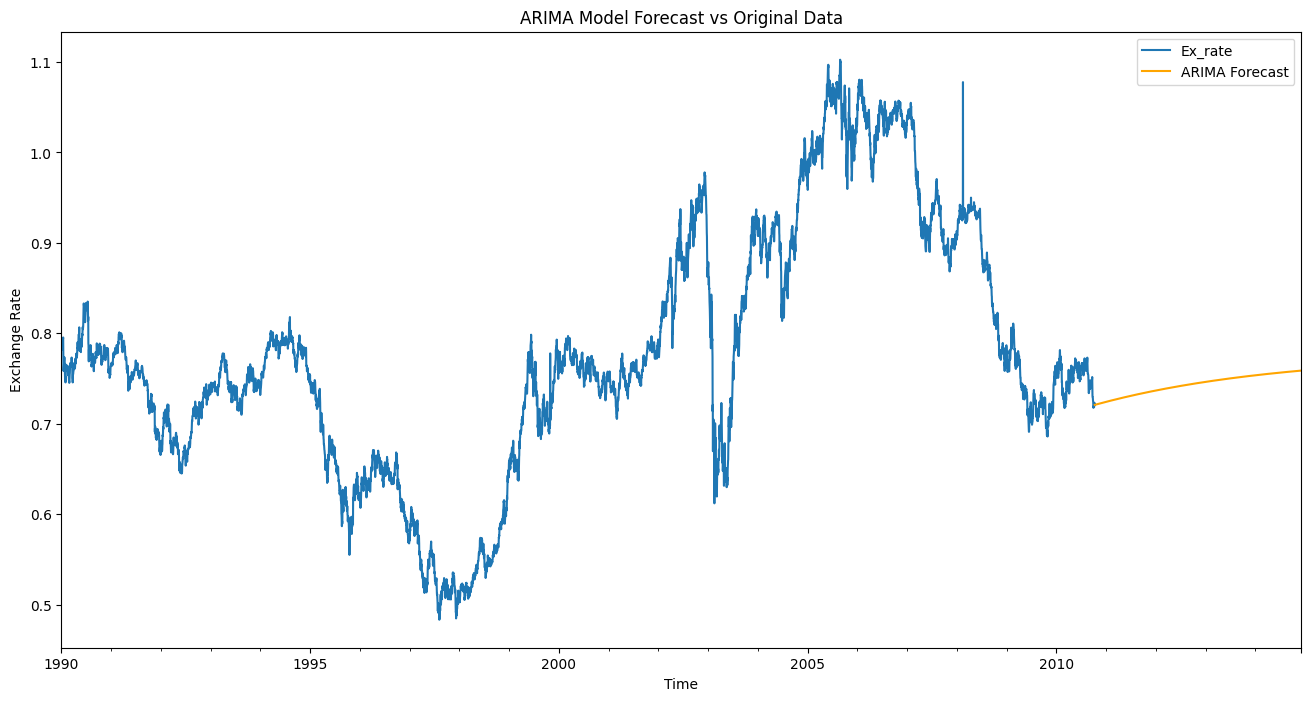

In [ ]:
# Plot the original data

df.plot(label='Original Data',figsize=(16,8))

# Plot the forecast
forecast_arima.plot(label='ARIMA Forecast', color='orange',figsize=(16,8))

# Add labels and title
plt.title('ARIMA Model Forecast vs Original Data')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend(loc='best')

# Show the plot
plt.show()

### Holts Winter Model

In [ ]:
configurations = [
    ('add', 'add', 12),  # Additive trend and additive seasonality
    ('add', 'mul', 12),  # Additive trend and multiplicative seasonality
    ('mul', 'add', 12),  # Multiplicative trend and additive seasonality
    ('mul', 'mul', 12),  # Multiplicative trend and multiplicative seasonality
]

# Loop through each configuration and evaluate performance
best_rmse = float('inf')
best_config = None

for trend, seasonal, period in configurations:
    try:
        # Fit Holt-Winters model
        hw_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=period).fit()
        hw_forecast = hw_model.forecast(len(test))

        # Calculate RMSE
        hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))

        # Print the configuration and RMSE
        print(f"Config: Trend={trend}, Seasonal={seasonal}, RMSE={hw_rmse:.3f}")

        # Update best RMSE and config
        if hw_rmse < best_rmse:
            best_rmse = hw_rmse
            best_config = (trend, seasonal)

    except Exception as e:
        print(f"Error with config {trend}-{seasonal}: {e}")

print(f"\nBest Configuration: Trend={best_config[0]}, Seasonal={best_config[1]}, RMSE={best_rmse:.3f}")

Config: Trend=add, Seasonal=add, RMSE=0.239
Config: Trend=add, Seasonal=mul, RMSE=0.238
Config: Trend=mul, Seasonal=add, RMSE=0.235
Config: Trend=mul, Seasonal=mul, RMSE=0.237

Best Configuration: Trend=mul, Seasonal=add, RMSE=0.235


In [ ]:

best_config = ('mul', 'add')

# Fit the Holt-Winters model with the best configuration
hw_model = ExponentialSmoothing(train, trend=best_config[0], seasonal=best_config[1], seasonal_periods=12).fit()

# Forecast
hw_forecast = hw_model.forecast(len(test))

# Evaluate the forecasts using MAE, RMSE, and MAPE
mae = mean_absolute_error(test, hw_forecast)
rmse = np.sqrt(mean_squared_error(test, hw_forecast))
mape = mean_absolute_percentage_error(test, hw_forecast)

# Store results in a DataFrame
Holt_Winter_results_df = pd.Series({"MAE": mae, "RMSE": rmse, "MAPE": mape}, name="Scores")
Holt_Winter_results_df


,Scores
MAE,0.203358
RMSE,0.235376
MAPE,0.260942


A Holt-Winters model is used, which is suitable for time series data with trend and seasonality. Different configurations (additive/multiplicative trend and seasonality) are tested to find the best fit. The RMSE is calculated to evaluate its performance. The final Holt-Winters model is used to forecast future exchange rate values, and the forecast is plotted against the original data.

### Holts Winter Visualization

In [ ]:
model_exp=ExponentialSmoothing(df,trend='mul',seasonal='add',seasonal_periods=12)
results_exp=model_exp.fit()
forecast_exp=results_exp.forecast(len(test))

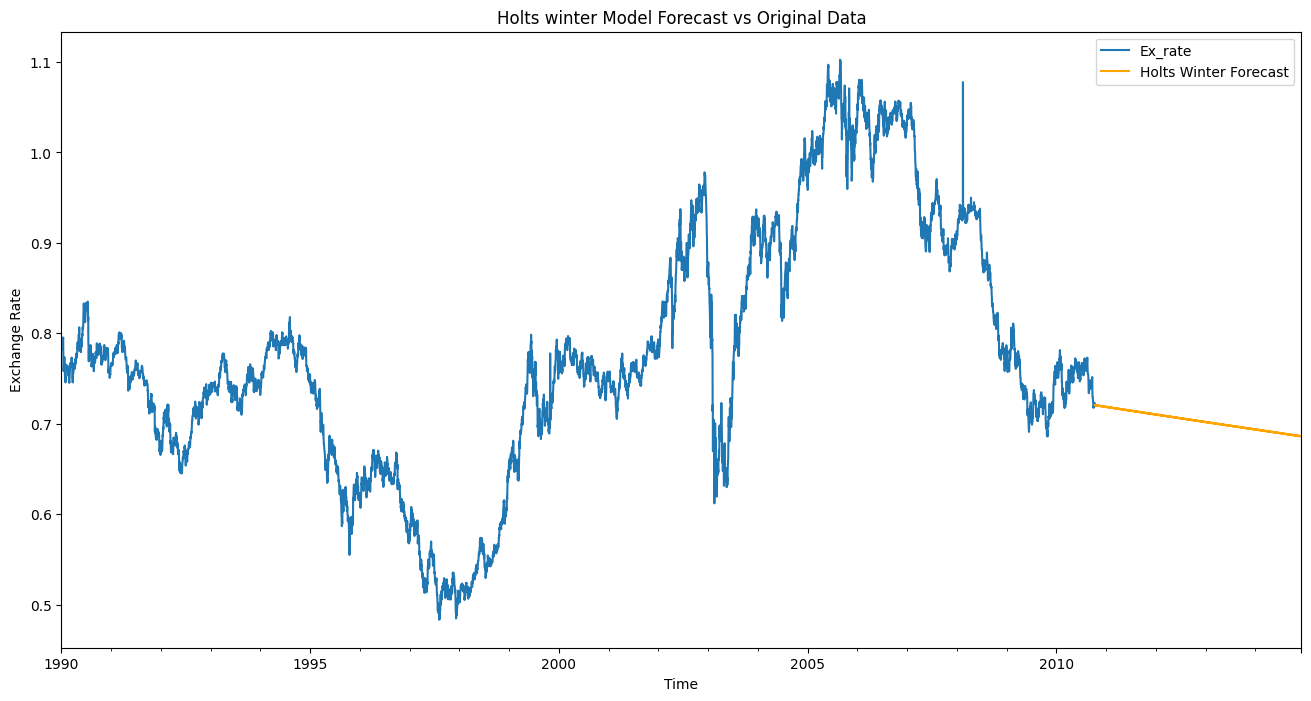

In [ ]:
# Plot the original data

df.plot(label='Original Data',figsize=(16,8))

# Plot the forecast
forecast_exp.plot(label='Holts Winter Forecast', color='orange',figsize=(16,8))

# Add labels and title
plt.title('Holts winter Model Forecast vs Original Data')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend(loc='best')

# Show the plot
plt.show()

### Conclusion:

Three time series forecasting models—Naive Bayes, ARIMA, and Holt-Winters—were evaluated for their ability to predict exchange rates.  

The Naive Bayes model achieved an RMSE of 0.205, serving as a baseline.  

The ARIMA model, after hyperparameter tuning, demonstrated superior performance with an RMSE of 0.117, along with a MAE of 0.099 and MAPE of 0.127.

The Holt-Winters model exhibited an RMSE of 0.235, a MAE of 0.203 and MAPE of 0.261.  

Based on these metrics, the ARIMA model provided the most accurate forecasts among the three, suggesting its effectiveness in capturing the underlying patterns and trends within the exchange rate data.